In [2]:
#Imports
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import os.path
from os import remove
import random
from time import time
import string
import webbrowser
import numpy as np
import matplotlib.pyplot as plt
import string
import re
from fuzzywuzzy import process
import glob
from IPython.core.debugger import set_trace


def text_between_subtrings(s, start, end):
    return s.find(start), s.find(end)

def wordify(question, max_words=30):
    question_words=question.split()
    if len(question_words)>max_words:
        question_words=question_words[:max_words]
    q=' '.join(question_words)
    q=re.sub(' to power of ', '^', q)
    q=re.sub('with subscript\(\(', '', q)
    q=re.sub('\)\)', '', q)
    q=re.sub('\d+\) _+', '', q)#these two lines get rid of any 3) _______ crap
    q = re.sub('#\)', '', q)
    return q.strip()

def wordify_answers(answer, max_words=30):
    answer_words=answer.split()
    if len(answer_words)>max_words:
        answer_words=answer_words[:max_words]
    q=' '.join(answer_words)
    q=re.sub(' to power of ', '^', q)
    if len(answer_words)>1:
        q=re.sub('[\bA-E]\)', '', q)#strips the A) for all except the version question
    return q.strip()

def extract_questions(s, max_words=10):
    more='yes'
    n=1
    questionlist=[]
    while more=='yes':
        start = '\n'+str(n)
        end = '\n'+str(n+1)
        p1, p2 = text_between_subtrings(s, start, end)
        if p1!=-1 and p2!=-1:
            txt=s[p1+len(start):p2]
            ###Grab the part between ) and nA, and convert into words
            pp1, pp2 = text_between_subtrings(txt, ')', '\nA')
            txt=txt[1:txt.find('\nA')]
            txt=wordify(txt,max_words)
            questionlist.append(txt)
            n+=1
        elif p1!=-1 and p2==-1:
            txt=s[p1+len(start):]
            pp1, pp2 = text_between_subtrings(txt, ')', '\nA')
            txt=txt[1:txt.find('\nA')]
            txt=wordify(txt,max_words)
            #re.sub('[^A-Z]', '', s)
            questionlist.append(txt)
            more='no'
        else:
            print("Sum ting wong. Shouldn't go here. p1= "+str(p1)+" p2= "+str(p2))
            more='no'
    return questionlist
    


def createQuestionIDs_and_dfs(test_name="key", max_words=30):
#     set_trace()
    All_IDs=[]
    dfs=[]
    for n in range(0,6):
        filename=test_name+str(n)+".txt"
        if (os.path.isfile(filename)):
            with open(filename, encoding="utf-8") as file:  
                data = file.read()
            p=data.rfind('\n\n\n\n1)')
            if p!=-1: 
                questions=data[:p]
            else:
                print('Make sure questions and answers in key'+str(n)+' are separated by \n\n\n\n')
                return []
            if questions.find('version is this')==-1:
                print('Make sure there is a version question with the words "version is this". ')
                return []
            
            qids=extract_questions(questions, max_words)
            qnum=len(qids)
            np_qids=np.array(qids).reshape(qnum,1)
            All_IDs.append(qids)
            
            
            aa=extract_choices(questions, qnum)
            np_aa=np.array(aa).reshape(qnum,len(aa[0]))
            v1=np.concatenate((np_qids,np_aa),axis=1)
            df=pd.DataFrame(v1,columns=["Question","A","B","C","D","E"],index=range(1,qnum+1))
            df['Blank']=''
            dfs.append(df)
    
    
    '''The following makes sure that question IDs are mapped one-to-one. 
    This will fail if the different versions are not of the same test'''
    for n in range(1,len(All_IDs)):
        assert(len(set(All_IDs[n]))==len(All_IDs[0])),"same question from v0 mapped to multiple questions in another version"
     
    '''This part takes All_IDs which stores the full text of the questions and assigns the numbers 
    0....N to the questions of the first version. These numbers then become identifiers for each question. 
    Example: version 0: [what, when, how] and version 1: [how, when, what]. these will become [0, 1, 2] and
    [2, 1, 0] respectively'''
    qids_new=[]
    qid_list=[x for x in range(0, qnum)]
    qids_new.append(qid_list)
    print("Generating QIDs. This might take a while..")
    starttime = time()
    for whichlist in All_IDs[1:]:
        qid_list=[1]*len(All_IDs[0])
        for m in range(0,len(All_IDs[0])):
            matching_question=process.extractOne(All_IDs[0][m], whichlist)[0]
            qid_list[whichlist.index(matching_question)]=m
        qids_new.append(qid_list)
    endtime = time()
    
    print("Done. That took: "+str(endtime-starttime)+ " sec.")
    return {"IDs":qids_new, "dfs":dfs}        

def extract_choices(s, qnum):
    all_choices=[]
    for n in range(1,qnum+1):
        txt=''
        start = '\n'+str(n)
        end = '\n'+str(n+1)
        p1, p2 = text_between_subtrings(s, start, end)
        if p1!=-1 and p2!=-1:
            txt=s[p1+len(start):p2]
        if p1!=-1 and p2==-1:
            txt=s[p1+len(start):]
        anslist=[]
        for m in range(0,4):
            start=chr(65+m)+')'
            end=chr(65+m+1)+')'
            #looking for answer choices as the text between A) and B) for example
            p1=txt.rfind(start)
            p2=txt.rfind(end)
            if p2!=-1:
                ans=txt[p1:p2].strip()
            else:
                ans=txt[p1:].strip()
            #if p2 was not found, do txt[p1:] rather than txt[p1:-1] which would truncate the last letter
            ans=wordify_answers(ans)
            if ans:
                anslist.append(ans)
            else:
                anslist.append('')
        if p2!=-1:
            ans=txt[p2:].strip()
            #ans=re.sub(' to power of ', '^', ans)
            ans=wordify_answers(ans)
            anslist.append(ans)
        else:
            anslist.append('')
        all_choices.append(anslist)
    return all_choices


def letter_to_number (letter_list):
    return [str(ord(x)-65) for x in letter_list]

def getAllKeys(test_name = "key", fixed_points_per_question=1, skipped_questions={}):
    '''read all files named key0-key4, make them into strings and and return a dictionary
    containing a list of keys and also the number of questions'''
    keylist=[]
    pointlist=[]
#     set_trace()
    for n in range(0,6):
        filename=test_name + str(n)+".txt"
        if (os.path.isfile(filename)):
            with open(filename, encoding="utf-8") as file: 
                data = file.read()
            u=re.search('\n\n\n\n+1\)',data)
            if u is not None:
                answers=data[u.start():].strip()
            else:
                print('Make sure questions and answers in key'+str(n)+' are separated by \n\n\n\n')
                return None
            ukey=re.findall(r'\d\)\s(.*?)\n+', answers)+re.findall(r'\d\)\s(.*?)$', answers)
            ukey=[x.split(', ') for x in ukey]
            key=[letter_to_number(x) for x in ukey]
            keylist.append(key)
            
            qnum=len(key)


            points=[fixed_points_per_question]*qnum
            if skipped_questions:
                for skipped_question in skipped_questions[n]:
                    points[skipped_question]=0
            
            points[-1]=0
            pointlist.append(points)
    
    assert(keylist), "Answerkeys not found. Make sure they are named key0.txt, key1.txt etc"
    return {"keylist":keylist,"pointlist":pointlist,"numberOfQuestions":qnum}

def make_special_question_list(freeqs, All_IDs):
    '''freeqs is an array of question numbers in version 0 that should be given full credit or skipped.
    Using the cross-reference table for questions between versions (All_IDs) this function
    creates a dictionary which lists which questions are to be given full credit for each version
    Example {0:[1,3], 1:[2,7]...} where [1,3] were the free questions in v0 and [2,7] are the same questions in v1'''
    
    
    exempt_list={}

    if not freeqs:
        return exempt_list
    
    qnos = set(range(1,len(All_IDs[0])+1))
    if not set(freeqs).issubset(qnos):
        print("Make sure to enter valid question numbers for version0(A)")
        return exempt_list
    else:
        freeqids = [x-1 for x in freeqs]
        for m in range(0,len(QIDs)):
            exempt_list[m] = [QIDs[m].index(x) for x in freeqids]
        return exempt_list

    

def process_grades(data,outs, QIDs,analysis=False,exempt_questions={}, skipped_questions={}):
    '''grades all exams using correct keys, writes questions missed and scores'''

    for NN in range(0, data.shape[0]):
        #print("NN: "+str(NN))
        ans=data.iat[NN,2]
        #if len(ans)==numberOfQuestions-1:
        if len(ans)==numberOfQuestions-1:
            v=guess_the_version(ans, exempt_questions, skipped_questions)
            ans = ans+str(v)
            print("Assuming version "+chr(65+v)+ " for: "+data.iat[NN,1]+" (Srl No: "+data.iat[NN,0]+").Last entry was missing" )
        if ans[-1]==" ":
            v=guess_the_version(ans, exempt_questions, skipped_questions)
            ans = ans[:-1]+str(v)
            print("Assuming version "+chr(65+v)+ " for: "+data.iat[NN,1]+" (Srl No: "+data.iat[NN,0]+").Last entry was a space")
        assert len(QIDs[0])==len(ans), "Failing for item {}, key = {}, ans = {}".format(NN, key, ans)
        check1=gradeWithKeylist(ans, outs, QIDs, analysis, NN, exempt_questions, skipped_questions)
        data.iat[NN,2]=ans
        data.iat[NN,3]=check1['missed']
        data.iat[NN,4]=check1['score']
        data.iat[NN,5]=100.0*float(check1['score'])/float(new_totalpoints)

    if analysis:
        #remove the column with the version numbers
        analysis_df.drop(analysis_df.columns[analysis_df.shape[1]-2], axis=1, inplace=True)
    return data


def gradeWithKeylist(ans,outs, QIDs, analysis=False, N=0, exempt_questions={}, skipped_questions={}):
    '''multiple versions - find the correct key as indicated on the last question on the exam 
    exempt_questions is a dictionary that says which questions are free (i.e. full points) for each version'''
#     set_trace()
    keylist=outs["keylist"]
    pointlist=outs["pointlist"]
    numberOfQuestions=outs["numberOfQuestions"] 
    
    assert(keylist!=[])
    assert (ans[-1:] in ['0','1','2','3','4'])
    whichKey=int(ans[-1:])
    
    key=keylist[whichKey]
    points=pointlist[whichKey]
    assert len(key)==len(ans), "Failing for item {}, key = {}, ans = {}".format(N, key, ans)
    missed=""
    rejalt = [1 if x > 0 else 0 for x in points]#this makes sure that a point is not given for a "skipped" question
    list_to_skip = []
    if exempt_questions:
        list_to_skip.append(exempt_questions[whichKey])
    if skipped_questions:
        list_to_skip.append(skipped_questions[whichKey])
    list_to_skip = [item for sublist in list_to_skip for item in sublist]# converts a list of lists into a single list
    if not list_to_skip:
        for n in range(0,len(key)-1):
            if not set(ans[n]).issubset(key[n]):
                ####If there are multiple correct answers to a question, then this allows for ANY subset of the correct choice getting full credit. 
                #### full credit. No credit for a correct  Use the == operator to give credit only when all correct choices have been picked. 
                missed+=str(n+1)+", "
                rejalt[n]=0
    else:
        for n in range(0,len(key)-1):
            if n not in list_to_skip:
                if not ans[n] in key[n]:
                    missed+=str(n+1)+", "
                    rejalt[n]=0

    ###Now we check if all were correct
    uu=list(missed)
    cors=[x for x in uu if x.isdigit()]##if any questions were missed their numbers will be in cors, otherwise cors will be empty
    if not cors:
        missed="v"+chr(65+whichKey)+": "+"ALL CORRECT"
    else:
        missed="v"+chr(65+whichKey)+": "+missed[:len(missed)-2]
    score=sum([i*j for i,j in zip(points,rejalt)])
    

    mydict1 = dict(zip(QIDs[whichKey],rejalt))
    #sortedIDs=sorted(mydict1.keys())
    sorted_rejalt=[mydict1[k] for k in QIDs[0]]####its sorted according to v0
    

    
    if analysis:   
        sorted_rejalt.append(score)
        analysis_df.loc[N] = sorted_rejalt 
    
      
    return {'missed':missed, 'score':score}

def guess_the_version(no_version, exempt={}, skipped ={}):
#     set_trace()
    scores=[]
    assert len(no_version) in [numberOfQuestions-1, numberOfQuestions]
    #last digit was a space so the last digit will be overwritten
    if len(no_version) == numberOfQuestions:
        try_version = no_version[:-1]
    #last digit was missing so the last digit will be added
    else:
        try_version = no_version
    for n in range(numberOfVersions):
        check1=gradeWithKeylist(try_version+str(n), outs, QIDs, analysis=False, exempt_questions=exempt, skipped_questions=skipped)
        scores.append(check1['score'])
    return scores.index(max(scores))



def make_into_percent(adf):
    '''Takes a dataframe and converts into np array to perform math operations.
    In this case it divides each element by the sum of the row and times by 100 to make it a percent.'''
    cols=list(adf)
    #adf=adf.applymap(float)
    np_df=adf.values
    np_df=100*np_df/np.sum(np_df, axis=1, keepdims=True)
    return pd.DataFrame(np_df,columns=cols)


def mark_correct_answers(pardf,n,keylist):
    
    key_to_use=keylist[n]
    for m in range(0,pardf.shape[0]):
        if len(key_to_use[m])==1:
            cor=int(key_to_use[m][0])
            pardf.iloc[m,cor]='[Correct] '+pardf.iloc[m,cor]
        else:
            cor_list=[int(x) for x in key_to_use[m]]
            for cor in cor_list:
                pardf.iloc[m,cor]='[Correct] '+pardf.iloc[m,cor]
                
    return pardf



def analyse_items(df, koschen_paper, keylist):
    '''create separate dfs with how many marked correct for each version separately'''

    outvars=[]
    versionsfound=[]
    students_in_this_version=[]
    
    just_answers_df=df.loc[:,"Answers"]
    just_answers_df=just_answers_df.apply(str)
    just_answers_df=just_answers_df.apply(lambda x: x.replace(' ', 'b'))
    just_answers_df=just_answers_df.apply(lambda x: ' '.join(list(x)))
    just_answers_df=just_answers_df.str.split(' ', expand=True)

    for n in range(0,len(koschen_paper)):
        ##get answers for version n
        part_df = just_answers_df.loc[just_answers_df[list(just_answers_df)[-1]] == str(n)]
        if not part_df.empty:
            print("Analysing data for version: "+chr(n+65))
            part_df = part_df.T
            part_df = part_df.apply(pd.Series.value_counts, axis = 1).fillna(0)
            if 'b' in list(part_df):
                part_df.rename(columns = {'b': 'Blank'}, inplace = True)
            vers = list(part_df)
            if 'Blank' in vers: 
                vers.remove('Blank')
            lvers = [chr(int(x)+65) for x in vers]
            part_df.rename(columns = dict(zip(vers,lvers)), inplace=True)
            num_students_this_version = part_df.iloc[0,:].sum()
            part_df = make_into_percent(part_df)
            part_df = part_df.applymap('{:,.0f}%'.format)
            if not 'Blank' in list(part_df):
                part_df['Blank']=''
            question_list = list(koschen_paper[n].loc[:,"Question"])
            part_df.index = question_list
            kp = koschen_paper[n].copy()
            kp.set_index("Question", inplace = True)
            kp.index.name = None ###This prevents an extra fictitious row from showing up in the header row

            part_df = kp+"<<"+part_df+">>"
            part_df = part_df.applymap(lambda m: re.sub('<<0%>>', '', m) )
            part_df = part_df.applymap(lambda m: re.sub('<<>>', '', m) )
            part_df = mark_correct_answers(part_df,n,keylist)

            outvars.append(part_df)
            versionsfound.append(lvers[n])
            students_in_this_version.append(num_students_this_version)
    
    
#     Return two dict so that the html function knows which version each table belongs to, and how many students took that version    
    return dict(zip(versionsfound,outvars)), dict(zip(versionsfound,students_in_this_version))

    
def make_item_analysis(a_df, qlist):
    
    item_analysis_df=pd.DataFrame(index=["Difficulty","Discrimination"],columns = list(analysis_df))
    n=a_df.shape[0]
    v=analysis_df.values#converts into np array
    
    
    #Calculating Difficulty
    u1=np.sum(v,axis=0)/n
    item_analysis_df.loc["Difficulty"]=u1[0:u1.shape[0]]
    
    #Calculating Discrimination
    students_per_group=n//3
    if students_per_group<2:
        print("Need more students for discrimination analysis (at least 7).")
        return item_analysis_df
    else:
        v=v[0:v.shape[0]-1,:]#exclude the bottom row which had the sums (total number correct for each q)
        v=v[v[:,v.shape[1]-1].argsort()[::-1]]#sort descending by scores
        #print(v)
        u1=np.sum(v[0:students_per_group,:],axis=0)#top scorers
        u2=np.sum(v[n-students_per_group-1 : n,:],axis=0)#bottom scorers
        disc=(u1-u2)/students_per_group
        disc.shape
        item_analysis_df.loc["Discrimination"]=disc[0:disc.shape[0]]
    
    item_analysis_df.drop("score", axis=1, inplace=True)
    item_analysis_df = item_analysis_df.T
    item_analysis_df.index = qlist[:-1]
    
    return item_analysis_df
    

#################Writing data#############################
def write_to_xl(adf, rfilename):
    adf.rename(columns={'Srl No': 'Serial Number Text Grade <Text>'})#This facilitates the Vlookup later
    writer = pd.ExcelWriter(rfilename+'_processed.xlsx')
    adf.to_excel(writer,'Sheet1',index=False)
    writer.save()
    
def write_to_csv(adf, rfilename):
    adf.drop("Answers", axis=1, inplace=True)
    filename = rfilename+'_processed.csv'
    #adf=adf.rename(columns={'Srl No': 'Serial Number Text Grade <Text>'})#This facilitates the Vlookup later
    adf.to_csv(filename, index=False)
    

def write_to_webpage(j_df, ia_df, pointdrop, ncbv={}, sbv={}, list_of_free_qs={}, list_of_skipped_qs={}, histobin=11):
    filename = rawdatafilename+'_summary.html'
    f = open(filename,'w',encoding='utf8')
    
    max_score=max(j_df['Score'])
    number_of_maxes=len([x for x in j_df['Score'] if x==max_score])
    
    uu=j_df['Percentage'].describe().to_frame()
    uu.rename(columns={'Percentage': "Value"}, index={'count':'Number of Students','mean':'Mean(%)', 'std':'Standard Deviation', 'min':'Lowest(%)','25%':'25th percentile', '50%':'50th percentile', '75%':'75th percentile', 'max':"Highest(%)"},inplace=True)
    uu.loc['Maximum Points Available '] = [int(new_totalpoints)]
    uu.loc['Highest Score '] = [int(max_score)]
    uu.loc['Number of Top Scorers'] = number_of_maxes
    uu.loc['Points dropped '] = pointdrop
#     set_trace()
    if list_of_free_qs:
        uu.loc['Free Questions '] = len(list_of_free_qs[0])
    if list_of_skipped_qs:
        uu.loc['Skipped Questions '] = len(list_of_skipped_qs[0])
        

    pre="<h2>Summary Data:</h2>"
    summary_table=uu.to_html(float_format=lambda x: '%10.2f' % x).replace("dataframe" ,"sumdat")
    summary_table=pre+summary_table
    post="<p>Score Distribution:</p>"
    
    figure = plt.figure()
    df['Percentage'].plot(kind='hist', bins=10)
    plt.xlim(right=100*totalpoints/new_totalpoints)
    figure.savefig('histo.svg')
    
    pre="<h2>Score Distribution:</h2>"
    image_code='<img src="histo.svg" alt="histogram">'
    image=pre+image_code

    pre="<h2>Item Analysis:</h2>"
    item_analysis_table=ia_df.sort_values('Difficulty').to_html(float_format=lambda x: '%10.2f' % x).replace("dataframe" ,"customers")
    item_analysis_table=pre+item_analysis_table

    missed_tables=""
    if ncbv:
        for ver in ['A', 'B','C','D','E']:
            if ver in ncbv.keys():
                if sbv:
                    nn=str(int(sbv[ver]))
                    pre="<h2>Distractor Analysis for Version "+ver+": ("+nn+" Students) </h2>"
                else:
                    pre="<h2>Distractor Analysis for Version "+ver+":</h2>"
                post=ncbv[ver].to_html()
                post=post.replace("dataframe" ,"howmany")
                post=post.replace('<td>[Correct]','<td class="correct">')
#                 post=post.replace('&lt;:','<span class="answered_by">')
#                 post=post.replace(':&gt;','</span>')
                post=re.sub('&lt;&lt;','<span class="answered_by">',post)
                post=re.sub('&gt;&gt;','</span>',post)
                missed_tables+=pre+post

    ##insert a script to make the webpage latex compatible. Edit the final  html file as \( \latex\code \)
    html_start = """<html>
    <head>
     <link rel="stylesheet" type="text/css" href="mystyle.css">
    <script type="text/javascript" async
    src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/latest.js?config=TeX-MML-AM_CHTML" async>
    </script>
    </head>
    <body>
    <h1>Data Analysis</h1>
    """


    html_end='''</body>
    </html>'''
    message=html_start+summary_table+image+item_analysis_table+missed_tables+html_end
    f.write(message)
    f.close()
    

    #Change path to reflect file location
    webbrowser.open_new_tab(filename)

###############################################

############### Checking for incorrect Srl Nos################


def check_serial_numbers(gradebook,datafile):
    df=pd.read_csv(gradebook, usecols=["Last Name", "First Name", "Serial Number Text Grade <Text>"])
    df_all=pd.read_excel(datafile, header=None, usecols=[0,1],names = ["Serial Number Text Grade <Text>", "Name"])

    checker_left = pd.merge(df,df_all[['Serial Number Text Grade <Text>','Name']],on='Serial Number Text Grade <Text>', how='left')
    checker_right = pd.merge(df,df_all[['Serial Number Text Grade <Text>','Name']],on='Serial Number Text Grade <Text>', how='right')
    u1=checker_left[checker_left.isnull().any(axis=1)]
    u2=checker_left[checker_left['Serial Number Text Grade <Text>'].duplicated(keep=False)]
    u3=checker_right[checker_right.isnull().any(axis=1)]
    error_rpt=pd.concat([u1, u2, u3], axis=0)
    error_rpt["Last Name"] = error_rpt["Last Name"]+' '+error_rpt['First Name']
    error_rpt.drop('First Name', axis=1,inplace=True)
    error_rpt.rename(columns={'Serial Number Text Grade <Text>': 'Srl No', 'Last Name':'Registered Name', 'Name':'Entered Name'}, inplace=True) 
    return error_rpt

################ Trash fakes #############
def trash_files(filename_to_remove):
    fakes = glob.glob(filename_to_remove)
    if fakes:
        for file in fakes:
            os.remove(file)
            print("{} removed".format(file))
        print("All {} Removed!".format(filename_to_remove))

print("All imports complete")

All imports complete


In [1]:
%run grader_funs.py

Imports completed at 16:58:20


Manually convert the dat file into an excel file using excel. Only extract the serial number,
name and Answers, and make sure Answers is text.
**Serial number should not be text**

In [3]:
#COLLECTING DATA
## The code will calculate automatically whether to use All or All_fakes (It will use All_fakes only if All if not available. 
## Use the following lines only to over-ride this)
# rawdatafilename='All'
# datafilename=rawdatafilename+'.xlsx'

rawdatafilename = ''
if os.path.exists("All.xlsx"):
    rawdatafilename='All'
    datafilename=rawdatafilename+'.xlsx'
    trash_files('*fake*')

if os.path.exists("All_fakes.xlsx"):
    rawdatafilename='All_fakes'
    datafilename=rawdatafilename+'.xlsx'

assert rawdatafilename, "Make sure either All or All_fakes is ready"
print("Using data from {}.xlsx".format(rawdatafilename))


gradebook='BSGrades.csv'
assert(os.path.isfile(datafilename)),'Make sure '+datafilename+" is ready"
assert(os.path.isfile(gradebook)),'Make sure '+gradebook+' is ready'

df = pd.read_excel(datafilename, header=None, usecols=[0,1,2], names = ["Srl No", "Name", "Answers"], dtype='str')
#parse_cols makes sure that only cols 0,1 and 2 are extracted
just_answers_df=df.loc[:,"Answers"]
#checking for blanks, print only if blanks found
asterisks = False
blankers=df[df['Answers'].str.contains(" ")]
stars = df[df['Answers'].str.contains('\*')]
if not blankers.empty:
    print("The following scantrons had blanks in them. Please resolve before proceeding.")
    display(blankers)
if not stars.empty:
    print("The following scantrons were flagged as unclear. Please resolve before proceeding.")
    display(stars)
    asterisks = True
ER=check_serial_numbers(gradebook,datafilename)
if not ER.empty:
    display(ER)

df["Missed"] = ""
df["Score"]=0
df["Percentage"]=np.nan
number_of_questions_from_scantrons=len(df.loc[0,"Answers"])

Using data from All.xlsx
The following scantrons had blanks in them. Please resolve before proceeding.


,Srl No,Name,Answers
125,1139,MICHAEL FINN-HENRY,22311120432223200 30311120
143,1158,EDUARD TATARU,04334 00304114333014142231


,Registered Name,Srl No,Entered Name
1,Aburto Julio Luis,1054,NaN
20,Choi Ryan,1061,NaN
144,Zisengwe Franklin,1075,NaN


In [4]:
assert not asterisks, "Please resolve the answerkeys with *'s in them before proceeding'"


##################### Free or skipped questions######################
freebies=[]#enter ACTUAL QUESTION NUMBER of questions from version 0(A) to which to award full credit regardless of response
skipped_questions=[]#enter ACTUAL QUESTION NUMBER of questions from version 0(A) to which to skip
#####################################################################


points_per_question=3
#determining whether the test in question is a final or a midterm. 3 points dropped for a final and 2 points dropped for a midterm
tstfiles=glob.glob("*.tst")
tstname = tstfiles[0][:-5]
 
if bool([x for x in tstfiles if "final" in x.lower()]):
    point_drop = 3
    print("Grading out of total - 3 since this is the final.")
else:
    point_drop = 2
    print("Grading out of total - 2 since this is a midterm.")


assert os.path.exists(tstname+"0.txt") |  os.path.exists("key0.txt"), "answerkey0 not found. Make sure it is named key0.txt or something like 2019_test1v0.txt"
  
if not os.path.exists(tstname+"0.txt"):
        tstname = "key"
print("Assuming answerkey files are in the .txt files named {}".format(tstname))      
    

if freebies:
    print("{} questions are being awarded free points!".format(len(freebies)).upper())


if skipped_questions:
    print("{} questions are being skipped!".format(len(skipped_questions)).upper())

quids_dfs=createQuestionIDs_and_dfs(tstname, max_words=50)
QIDs=quids_dfs["IDs"]
exempts=make_special_question_list(freebies, QIDs)
skipped = make_special_question_list(skipped_questions, QIDs)

outs = getAllKeys(tstname, points_per_question, skipped)
keylist=outs["keylist"]
pointlist=outs["pointlist"]
numberOfQuestions=outs["numberOfQuestions"]
assert number_of_questions_from_scantrons == numberOfQuestions, "The number of questions on the test ({}) does not match the number of questions on the scantron ({})".format(numberOfQuestions,number_of_questions_from_scantrons)
assert sum(pointlist[0]) == sum(pointlist[1]) ==sum(pointlist[2]) == sum(pointlist[3]), "Total number of points on each version should be the same"
totalpoints=sum(pointlist[2])
new_totalpoints=totalpoints-point_drop
numberOfVersions=len(keylist)
numberOfStudents=df.shape[0]

koschen_paper=quids_dfs['dfs']
v0_question_list = list(koschen_paper[0].loc[:,"Question"]) #List of questions in version 0
assert(keylist and pointlist and QIDs and koschen_paper and numberOfQuestions!=0),"Either keylist or pointlist or QIDs or koschen_paper or  numberOfQuestions is null"


analysis_df  = pd.DataFrame(index=range(numberOfStudents),columns = list(QIDs[0])+["score"])# stores whether answer was correct, questions are the columns, last column is the score


Grading out of total - 3 since this is the final.
Assuming answerkey files are in the .txt files named 2019fall-final_v
Generating QIDs. This might take a while..
Done. That took: 2.6555495262145996 sec.


In [5]:
##Everything initialized. Running the code now
# too_few_answers =  df[df['Answers'].map(len)<numberOfQuestions-1]
# too_many_answers =  df[df['Answers'].map(len)>numberOfQuestions]
# stranges = [too_few_answers, too_many_answers]
# too_many_or_too_few = False
# for strange in stranges:
#     if not strange.empty:
#         display(strange[['Srl No', 'Name','Answers']])
#         too_many_or_too_few = True
# assert not too_many_or_too_few, "Check that all answer strings have correct length"   

incorrect_length =  df[(df['Answers'].map(len)<numberOfQuestions-1) | (df['Answers'].map(len)>numberOfQuestions)]
if not incorrect_length.empty:
    incorrect_length=incorrect_length[['Srl No', 'Name','Answers']]
    print("The following students had too many or too few answers")
    display(incorrect_length)
assert incorrect_length.empty, "Check that all answer strings have correct length" 

last_entry_missing=df[df['Answers'].map(len)==numberOfQuestions-1]
if not last_entry_missing.empty:
    last_entry_missing=last_entry_missing[['Srl No', 'Name','Answers']]
    print("The following students had no entry for the version question")
    display(last_entry_missing)
last_entry_space = df[(df['Answers'].str[-1] == ' ') & (df['Answers'].map(len) == numberOfQuestions)]
if not last_entry_space.empty:
    last_entry_space=last_entry_space[['Srl No', 'Name','Answers']]
    print("The following students had a blank entered for version question")
    display(last_entry_space)

print("Starting calculations...")
starttime = time()

df=process_grades(df,outs, QIDs, analysis=True,exempt_questions=exempts,skipped_questions = skipped)
number_correct_by_version, students_by_version = analyse_items(df, koschen_paper,keylist)
item_analysis_df = make_item_analysis(analysis_df, v0_question_list) 
endtime = time()
print("Done. That took: "+str(endtime-starttime)+ " sec for "+str(numberOfStudents)+" students")
#check for duplicated serial numbers
dupes=df[df['Srl No'].duplicated(keep=False)]
if not dupes.empty:
    print('Warning: Duplicates in serial numbers found!')
    display(dupes)    
max_score=analysis_df.at[analysis_df['score'].idxmax(),'score']

Starting calculations...
Analysing data for version: A
Analysing data for version: B
Analysing data for version: C
Analysing data for version: D
Done. That took: 0.16335272789001465 sec for 144 students


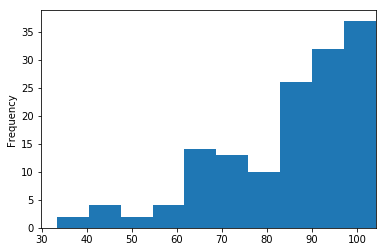

In [6]:
write_to_csv(df.sort_values('Score', ascending=False),rawdatafilename)
if (os.path.isfile('mystyle.css')):
    write_to_webpage(df, item_analysis_df, point_drop, number_correct_by_version, students_by_version, list_of_free_qs=exempts, list_of_skipped_qs=skipped)
else:
    print("Copy the css file over first")

In [ ]:
#Grades and displays the N'th entry in the list using a keylist
#N=random.randint(1,df.shape[0]-1)
# for N in range(df.shape[0]-1):
N=10
exempts=make_special_question_list(freebies, QIDs)
check1=gradeWithKeylist(df.iat[N,2], outs, QIDs, analysis=False, exempt_questions=exempts, skipped_questions=skipped)
print("Row "+ str(N)+": "+df.iat[N,1]+", "+str(df.iat[N,0])+". Missed "+str(check1['missed'])+ ". Scored "+str(check1['score'])+"/"+str(new_totalpoints))
print('That is: '+str(100*check1['score']/new_totalpoints)+'% with '+str(point_drop)+' points dropped')

In [ ]:
new_totalpoints

# DEVELOPMENT AREA
## All code below is in development


In [ ]:
just_answers_df=df.loc[:,"Answers"]
just_answers_df=just_answers_df.apply(str)
just_answers_df=just_answers_df.apply(lambda x: x.replace(' ', 'b'))
just_answers_df=just_answers_df.apply(lambda x: ' '.join(list(x)))
just_answers_df=just_answers_df.str.split(' ', expand=True)

n = 2
#just_answers_df.sort_values(list(just_answers_df)[-1])
part_df = just_answers_df.loc[just_answers_df[list(just_answers_df)[-1]] == str(n)]
if not part_df.empty:
    print("Analysing data for version: "+chr(n+65))
    part_df = part_df.T
    part_df = part_df.apply(pd.Series.value_counts, axis = 1).fillna(0)
    if 'b' in list(part_df):
        part_df.rename(columns = {'b': 'Blank'}, inplace = True)
    vers = list(part_df)
    if 'Blank' in vers: 
        vers.remove('Blank')
    lvers = [chr(int(x)+65) for x in vers]
    part_df.rename(columns = dict(zip(vers,lvers)), inplace=True)
    num_students_this_version = part_df.iloc[0,:].sum()
    part_df = make_into_percent(part_df)
    part_df = part_df.applymap('{:,.0f}%'.format)
    if not 'Blank' in list(part_df):
        part_df['Blank']=''
    question_list = list(koschen_paper[n].loc[:,"Question"])
    part_df.index = question_list
    kp = koschen_paper[n].copy()
    kp.set_index("Question", inplace = True)
    kp.index.name = None ###This prevents an extra fictitious row from showing up in the header row

    part_df = kp+"<"+part_df+">"
    part_df = part_df.applymap(lambda m: re.sub('<0%>', '', m) )
    part_df = part_df.applymap(lambda m: re.sub('<>', '', m) )
    part_df = mark_correct_answers(part_df,n,keylist)

In [ ]:
n=0
filename="key"+str(n)+".txt"
if (os.path.isfile(filename)):
    with open(filename, encoding="utf-8") as file: 
        data = file.read()
    u=re.search('\n\n\n\n+1\)',data)
#     answers=data[u.start():].strip()    
#     ukey=re.findall(r'\d\)\s(.*?)\n+', answers)+re.findall(r'\d\)\s(.*?)$', answers)
#     ukey=[x.split(', ') for x in uu]
#     key=[letter_to_number(x) for x in ukey]

In [ ]:
questions=data[:u.start()]

In [ ]:
qs=re.findall(r'\n\n\d\)(.*?)\n\n\d\)', questions)

In [ ]:
qs

In [ ]:
 uu=re.findall(r'\d\)\s(.*?)\n+', answers)+re.findall(r'\d\)\s(.*?)$', answers)

In [ ]:
qs

In [ ]:
# [x+1 if x >= 45 else x+5 for x in l]
ukey=[x.split(', ') for x in uu]

In [ ]:
def letter_to_number (letter_list):
    return [str(ord(x)-65) for x in letter_list]

In [ ]:
letter_to_number(['A'])

In [ ]:
ukey=[letter_to_number(x) for x in ukey]

In [ ]:
ukey

In [ ]:
m='4'
m in ukey[12]

In [ ]:
outs=getAllKeys(3)

In [ ]:
keylist=outs['keylist']

In [ ]:
keylist[0]

In [ ]:
post='<td class="correct"> True&lt;18%&gt;</td>'

In [ ]:
post

In [ ]:
post=re.sub('&lt;&lt;','<span class="answered_by">',post)
post=re.sub('&gt;&gt;','</span>',post)

In [ ]:
QIDs[0]

In [ ]:
QIDs[1]

In [ ]:
QIDs[2]

In [ ]:
QIDs[3]

In [ ]:
len(set(QIDs[1]))

In [ ]:
QIDs[3]=[1, 13, 6, 4, 7, 9, 3, 5, 12, 11, 0, 10, 8, 1, 14]

In [ ]:
for n in range(1,len(QIDs)):
    print(n)
    assert(len(set(QIDs[n]))==len(QIDs[0])),"same question from v0 mapped to multiple questions in another version"

In [ ]:
df.apply(lambda row: row.astype(str).str.contains('ANAWATE').any(), axis=1)

In [ ]:
df = pd.read_excel(datafilename, header=None, usecols=[0,1,2], names = ["Srl No", "Name", "Answers"], dtype='str')

In [ ]:
df.head()

In [ ]:
da = '1'

In [ ]:
import os
if os.path.exists("All.xlsx"):
    print("Using All")
elif os.path.exists("All_fakes.xlsx"):
    print("Using All_fakes.xlsx")
else:
    print("Make sure either All or All_fakes is ready.")

In [ ]:
assert da, "Hello"

In [ ]:
dd = df[df['Answers'].map(len)!=numberOfQuestions]

In [ ]:
dd =  df[df['Answers'].map(len) not [numberOfQuestions-1, numberOfQuestions].any()]

In [ ]:
assert dd.empty

In [ ]:
1 not in [1,5]

In [ ]:
u = "hello"
u[:-1]+'a'

In [ ]:
u[-1]

In [ ]:
ans = '24421124120221 '

In [ ]:
len(ans)

In [ ]:
ans[-1]

In [ ]:
ans[-1]==" "

In [ ]:
ans = ans[:-1]+str(0)

In [ ]:
ans

In [ ]:
QIDs

In [ ]:
len(QIDs[0])

In [ ]:
df[(df['Answers'].str[-1] == ' ') & (df['Answers'].map(len) == numberOfQuestions)]

In [ ]:
incorrect_length =  df[(df['Answers'].map(len)<numberOfQuestions-1) | (df['Answers'].map(len)>numberOfQuestions)]

In [ ]:
incorrect_length

In [ ]:
import glob
tstfiles=glob.glob("*.tst")
tstname = tstfiles[0][:-5]
# test_names = [x[:-4] for x in pdf_tests]
# tests_ending_with_digits = [x[:-1] for x in test_names if x[-1].isdigit()]

In [ ]:
tstfiles

In [ ]:
tstname = tstfiles[0][:-5]

In [ ]:
tstname

In [ ]:
skipped

In [ ]:
skipped[0]

In [ ]:
def getAllKeys(test_name = "key", fixed_points_per_question=1, skipped_questions={}):
    '''read all files named key0-key4, make them into strings and and return a dictionary
    containing a list of keys and also the number of questions'''
    keylist=[]
    pointlist=[]
#     set_trace()
    for n in range(0,6):
        filename=test_name + str(n)+".txt"
        if (os.path.isfile(filename)):
            with open(filename, encoding="utf-8") as file: 
                data = file.read()
            u=re.search('\n\n\n\n+1\)',data)
            if u is not None:
                answers=data[u.start():].strip()
            else:
                print('Make sure questions and answers in key'+str(n)+' are separated by \n\n\n\n')
                return None
            ukey=re.findall(r'\d\)\s(.*?)\n+', answers)+re.findall(r'\d\)\s(.*?)$', answers)
            ukey=[x.split(', ') for x in ukey]
            key=[letter_to_number(x) for x in ukey]
            keylist.append(key)
            
            qnum=len(key)


            points=[fixed_points_per_question]*qnum
            if skipped_questions:
                for skipped_question in skipped_questions[n]:
                    points[skipped_question]=0
            
            points[-1]=0
            pointlist.append(points)
    
    assert(keylist), "Answerkeys not found. Make sure they are named key0.txt, key1.txt etc"
    return {"keylist":keylist,"pointlist":pointlist,"numberOfQuestions":qnum}

In [ ]:
gak = getAllKeys(test_name = "key", fixed_points_per_question=3, skipped_questions = skipped)

In [ ]:
def gradeWithKeylist(ans,outs, QIDs, analysis=False, N=0, exempt_questions={}, skipped_questions={}):
    '''multiple versions - find the correct key as indicated on the last question on the exam 
    exempt_questions is a dictionary that says which questions are free (i.e. full points) for each version'''
    
    keylist=outs["keylist"]
    pointlist=outs["pointlist"]
    numberOfQuestions=outs["numberOfQuestions"] 
    
    assert(keylist!=[])
    assert (ans[-1:] in ['0','1','2','3','4'])
    whichKey=int(ans[-1:])
    
    key=keylist[whichKey]
    points=pointlist[whichKey]
    assert len(key)==len(ans), "Failing for item {}, key = {}, ans = {}".format(N, key, ans)
    missed=""
    rejalt = [1 if x > 0 else 0 for x in points]#this makes sure that a point is not given for a "skipped" question
    if not exempt_questions and not free_questions:
        for n in range(0,len(key)-1):
            if not set(ans[n]).issubset(key[n]):
                ####If there are multiple correct answers to a question, then this allows for ANY subset of the correct choice getting full credit. 
                #### full credit. No credit for a correct  Use the == operator to give credit only when all correct choices have been picked. 
                missed+=str(n+1)+", "
                rejalt[n]=0
    else:
        for n in range(0,len(key)-1):
            if not ans[n] in key[n] and n not in exempt_questions[whichKey]:
                missed+=str(n+1)+", "
                rejalt[n]=0
    if sum(rejalt)==numberOfQuestions:
        missed="v"+chr(65+whichKey)+": "+"ALL CORRECT"
    else:
        missed="v"+chr(65+whichKey)+": "+missed[:len(missed)-2]
    score=sum([i*j for i,j in zip(points,rejalt)])
    

    mydict1 = dict(zip(QIDs[whichKey],rejalt))
    #sortedIDs=sorted(mydict1.keys())
    sorted_rejalt=[mydict1[k] for k in QIDs[0]]####its sorted according to v0
    

    
    if analysis:   
        sorted_rejalt.append(score)
        analysis_df.loc[N] = sorted_rejalt 
    
      
    return {'missed':missed, 'score':score}


In [ ]:
sum(pointlist[0]) == sum(pointlist[1]) ==sum(pointlist[2]) == sum(pointlist[3])

In [ ]:
pointlist[1]

In [ ]:
rejalt = [1 if x > 0 else 0 for x in pl[1]]

In [ ]:
rejalt

In [ ]:
skipped

In [ ]:
numberOfQuestions

In [ ]:
pointlist

In [ ]:
print("{} questions are being awarded free points!".format(len(freebies)).upper())

In [ ]:
skipped[0]

In [ ]:
exempts

In [ ]:
number_correct_by_version['A']

In [ ]:
skipped

In [ ]:
exempts

In [ ]:
missed